# Improving Variational Quantum Optimization using CVaR
Panagiotis Kl. Barkoutsos, Giacomo Nannicini, Anton Robert, Ivano Tavernelli, Stefan Woerner

This notebook provides an implementation to reproduce the results published in
https://arxiv.org/abs/1907.04769. <br>
For more details we refer to the paper.

In [1]:
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.aqua.algorithms.adaptive.qaoa.var_form import QAOAVarForm
from qiskit.aqua.algorithms import ExactEigensolver
from qiskit.finance.ising import portfolio
from qiskit import execute, Aer
import numpy as np
import matplotlib.pyplot as plt

## Portfolio Optimization
In the following we define a random problem instance for portfolio optimization.<br>
Many translators for other optimization problems can be found in ``qiskit.optimization``

In [2]:
# prepare problem instance
n = 6  # number of assets
q = 0.5 # risk factor
budget = n // 2  # budget
penalty = 12  # penalty factor for equality constraints

In [3]:
# instance from paper
mu = np.array([0.7313, 0.9893, 0.2725, 0.8750, 0.7667, 0.3622])
sigma = np.array([
    [ 0.7312, -0.6233,  0.4689, -0.5452, -0.0082, -0.3809],
    [-0.6233,  2.4732, -0.7538,  2.4659, -0.0733,  0.8945],
    [ 0.4689, -0.7538,  1.1543, -1.4095,  0.0007, -0.4301],
    [-0.5452,  2.4659, -1.4095,  3.5067,  0.2012,  1.0922],
    [-0.0082, -0.0733,  0.0007,  0.2012,  0.6231,  0.1509],
    [-0.3809,  0.8945, -0.4301,  1.0922,  0.1509,  0.8992]
])

# or random instance
# mu, sigma = portfolio.random_model(n, seed=123)  # expected returns and covariance matrix

In [4]:
# derive cost Hamiltonian and constant offset
H, offset = portfolio.get_operator(mu, sigma, q, budget, penalty)

## Compute Optimal Solution Classically
Use the exact eigensolver to evaluate the optimal value classically. This is used to track the overlap with the optimal solution throughout the optimization.

In [5]:
exact_eigen_solver = ExactEigensolver(H)
optimal_value = exact_eigen_solver.run()['energy'] + offset
print('optimal_value = %.4f' % optimal_value)

optimal_value = -1.2784


## Variational Quantum Optimization

In [6]:
# set classical optimizer
optimizer = COBYLA(maxiter=50)

# set variational ansatz
var_form = RY(n, depth=1)
# var_form = QAOAVarForm(H, 1)  # use this ansatz for CVaR-QAOA
m = var_form.num_parameters

# set backend
backend = Aer.get_backend('statevector_simulator')
# backend = Aer.get_backend('qasm_simulator')  # use this for QASM simulator

In [7]:
def compute_cvar(probabilities, values, alpha):
    """ 
    Auxilliary method to computes CVaR for given probabilities, values, and confidence level.
    
    Attributes:
    - probabilities: list/array of probabilities
    - values: list/array of corresponding values
    - alpha: confidence level
    
    Returns:
    - CVaR
    """
    sorted_indices = np.argsort(values)
    probs = np.array(probabilities)[sorted_indices]
    vals = np.array(values)[sorted_indices]
    cvar = 0
    total_prob = 0
    for i, (p, v) in enumerate(zip(probs, vals)):
        done = False
        if p >= alpha - total_prob:
            p = alpha - total_prob
            done = True
        total_prob += p
        cvar += p * v
    cvar /= total_prob
    return cvar

In [8]:
def eval_bitstring(H, x):
    """
    Auxilliary method to evaluate the objective function for a given bitstring
    
    Attributes:
    - H: cost Hamiltonian
    - x: bitstring
    
    Returns:
    - objective value
    """

    # invert bitstring for convenience and translate to +/-1
    x = x[::-1]    
    spins = np.array([(-1)**(b == '1') for b in x])
    value = 0
    
    # loop over pauli terms and add contribution to objective
    for p in H.paulis:
        weight = np.real(p[0])
        indices = np.where(p[1].z)
        value += weight * np.prod(spins[indices])
    return value

In [9]:
class Objective:
    """
    Wrapper for objective function to track the history of evaluations
    """
    
    def __init__(self, var_form, H, offset, alpha, backend, optimal=None):
        self.history = []
        self.var_form = var_form
        self.H = H
        self.offset = offset
        self.alpha = alpha
        self.backend = backend
        self.optimal = optimal
        self.opt_history = []
    
    def evaluate(self, thetas):
    
        # create and run circuit
        qc = self.var_form.construct_circuit(thetas)
        job = execute(qc, self.backend)
        result = job.result()
        counts = result.get_counts()

        # evaluate counts
        probabilities = np.zeros(len(counts))
        values = np.zeros(len(counts))
        for i, (x, p) in enumerate(counts.items()):
            values[i] = eval_bitstring(self.H, x) + self.offset
            probabilities[i] = p
            
        # track optimal probability
        if self.optimal:
            indices = np.where(values <= self.optimal + 1e-8)
            self.opt_history += [sum(probabilities[indices])]
        
        # evaluate cvar
        cvar = compute_cvar(probabilities, values, self.alpha)
        self.history += [cvar]
        return cvar

In [10]:
# run variational optimization for different values of alpha
alphas = [1.0, 0.75, 0.5, 0.25]  # confidence levels to be evaluated
initial_point = np.random.rand(m)  # same random initial set of parameters for all experiments
objectives = {}  # set of tested objective functions w.r.t. alpha
for alpha in alphas:
    objectives[alpha] = Objective(var_form, H, offset, alpha, backend, optimal=optimal_value)
    optimizer.optimize(m, objectives[alpha].evaluate, initial_point=initial_point)

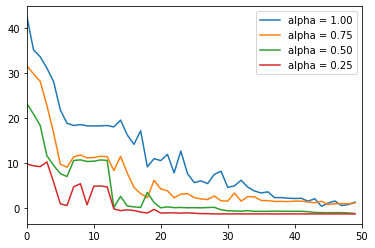

In [11]:
# plot resulting history of objective values
for alpha in alphas:
    plt.plot(objectives[alpha].history, label='alpha = %.2f' % alpha)
plt.legend()
plt.xlim(0, 50)
plt.show()

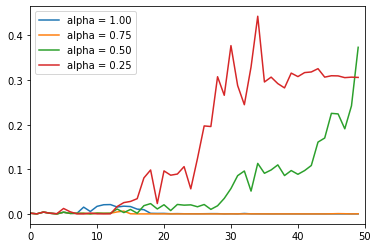

In [12]:
# plot resulting overlap with optimal solution
for alpha in alphas:
    plt.plot(objectives[alpha].opt_history, label='alpha = %.2f' % alpha)
plt.legend()
plt.xlim(0, 50)
plt.show()